In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys, joblib, json
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

# Add `src` to path for local imports
base_dir = Path('..')
sys.path.append(str(base_dir / 'src'))

# Visualization defaults
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Load Model and Data

In [59]:
# Load the trained model
model_path = base_dir / 'models' / 'insurance_model.pkl'
if not model_path.exists():
    raise FileNotFoundError(f'Model not found at: {model_path}. Run training notebook first.')
model = joblib.load(model_path)
print(f'Model loaded: {model_path.name} ({type(model).__name__})')

# Load test data
from data_processing import prepare_split
X_train, X_test, y_train, y_test = prepare_split()

# Drop identifier columns if present (prevent leakage)
for id_col in ['person_id', 'id', 'index']:
    X_train = X_train.drop(columns=[id_col], errors='ignore')
    X_test = X_test.drop(columns=[id_col], errors='ignore')

# Align evaluation features to model (if available) — best-effort
import warnings
if hasattr(model, 'feature_names_in_'):
    expected = list(model.feature_names_in_)
    missing = [c for c in expected if c not in X_test.columns]
    if missing:
        warnings.warn(f'Missing {len(missing)} feature(s); filling with zeros.', UserWarning)
    X_train = X_train.reindex(columns=expected, fill_value=0)
    X_test = X_test.reindex(columns=expected, fill_value=0)
else:
    # Use intersection fallback
    common = [c for c in X_test.columns if c in X_train.columns]
    X_train = X_train[common]
    X_test = X_test[common]

print(f'Loaded test set — samples: {X_test.shape[0]}, features: {X_test.shape[1]}')

Model loaded: insurance_model.pkl (RandomForestRegressor)
Loaded test set — samples: 20000, features: 69


## 2. Generate Predictions

In [60]:
# Generate predictions on both train and test sets with safety checks
from sklearn.exceptions import NotFittedError
from sklearn.impute import SimpleImputer

# If there are NaNs in the evaluation features, impute using the training set statistics
if X_train.isnull().any().any() or X_test.isnull().any().any():
    num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
    if num_cols:
        # Separate numeric cols that have at least one observed value in training
        observed_cols = [c for c in num_cols if X_train[c].notna().any()]
        missing_all_cols = [c for c in num_cols if c not in observed_cols]
        if observed_cols:
            imputer = SimpleImputer(strategy='mean')
            # Fit on training numeric columns that have observed values
            imputer.fit(X_train[observed_cols])
            # Transform and restore DataFrame structure for observed columns
            X_train[observed_cols] = imputer.transform(X_train[observed_cols])
            X_test[observed_cols] = imputer.transform(X_test[observed_cols])
        # For numeric columns with no observed values in training, fill with zeros
        if missing_all_cols:
            X_train[missing_all_cols] = X_train[missing_all_cols].fillna(0)
            X_test[missing_all_cols] = X_test[missing_all_cols].fillna(0)
    else:
        # No numeric columns to impute; fill all NaNs with zeros as fallback
        X_train = X_train.fillna(0)
        X_test = X_test.fillna(0)

def safe_predict(model, X, name=''):
    try:
        # If model recorded feature names at fit time, ensure the input has the same columns
        if hasattr(model, 'feature_names_in_') and isinstance(X, pd.DataFrame):
            expected = list(model.feature_names_in_)
            if list(X.columns) != expected:
                X = X.reindex(columns=expected, fill_value=0)
        preds = model.predict(X)
        return np.asarray(preds)
    except NotFittedError as e:
        raise NotFittedError('Model is not fitted. Fit the model before predicting.') from e
    except Exception as e:
        raise RuntimeError(f'Prediction failed for {name}: {e}') from e

y_train_pred = safe_predict(model, X_train, 'train')
y_test_pred = safe_predict(model, X_test, 'test')

print("Predictions generated successfully")
print(f"\nTrain set predictions shape: {y_train_pred.shape}")
print(f"Test set predictions shape: {y_test_pred.shape}")

print(f"\nPredictions statistics (Test):")
print(f"  Min: ${y_test_pred.min():.2f}")
print(f"  Max: ${y_test_pred.max():.2f}")
print(f"  Mean: ${y_test_pred.mean():.2f}")
print(f"  Std: ${y_test_pred.std():.2f}")

Predictions generated successfully

Train set predictions shape: (80000,)
Test set predictions shape: (20000,)

Predictions statistics (Test):
  Min: $98.83
  Max: $57002.51
  Mean: $3026.94
  Std: $3115.16


## 3. Calculate Metrics

In [61]:
metrics = {}

train_metrics = {
    'MAE': mean_absolute_error(y_train, y_train_pred),
    'RMSE': np.sqrt(mean_squared_error(y_train, y_train_pred)),
    'MAPE': mean_absolute_percentage_error(y_train, y_train_pred),
    'R2': r2_score(y_train, y_train_pred)
}

test_metrics = {
    'MAE': mean_absolute_error(y_test, y_test_pred),
    'RMSE': np.sqrt(mean_squared_error(y_test, y_test_pred)),
    'MAPE': mean_absolute_percentage_error(y_test, y_test_pred),
    'R2': r2_score(y_test, y_test_pred)
}

metrics['train'] = train_metrics
metrics['test'] = test_metrics


In [62]:

print("\n" + "="*80)
print("OVERFITTING ANALYSIS")
print("="*80)

r2_diff = train_metrics['R2'] - test_metrics['R2']
mae_diff = test_metrics['MAE'] - train_metrics['MAE']

print(f"\nR² Score Difference (Train - Test): {r2_diff:.4f}")
if r2_diff > 0.1:
    print("  ⚠ Possible overfitting detected")
elif r2_diff > 0.05:
    print("  ⚠ Minor overfitting detected")
else:
    print("  ✓ Model generalization is good")

print(f"\nMAE Difference (Test - Train): ${mae_diff:.2f}")


OVERFITTING ANALYSIS

R² Score Difference (Train - Test): 0.0017
  ✓ Model generalization is good

MAE Difference (Test - Train): $5.03


## 5. Actual vs Predicted Visualization

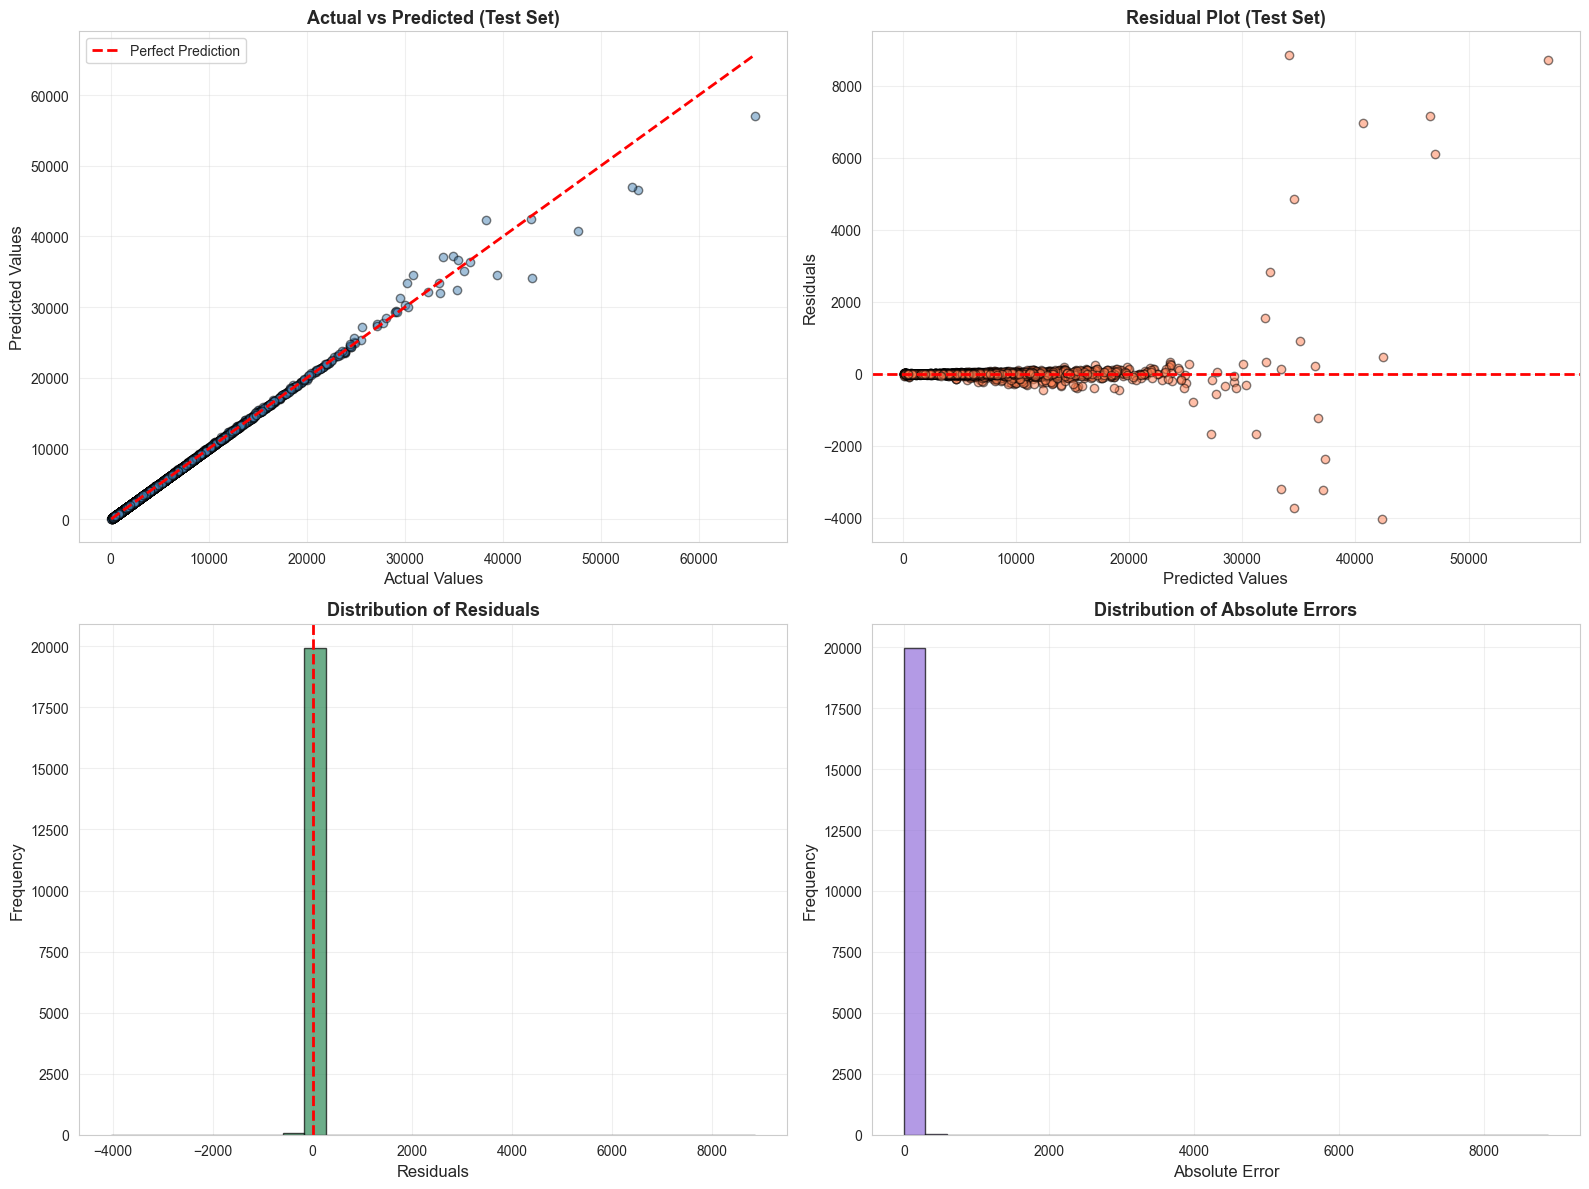


Residuals Statistics (Test Set):
  Mean: $0.85
  Std: $141.37
  Min: $-4035.46
  Max: $8873.62


In [63]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Actual vs Predicted (Test Set)
axes[0, 0].scatter(y_test, y_test_pred, alpha=0.5, color='steelblue', edgecolors='k')
axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
axes[0, 0].set_xlabel('Actual Values', fontsize=12)
axes[0, 0].set_ylabel('Predicted Values', fontsize=12)
axes[0, 0].set_title('Actual vs Predicted (Test Set)', fontsize=13, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Residuals vs Predicted
residuals_test = y_test - y_test_pred
axes[0, 1].scatter(y_test_pred, residuals_test, alpha=0.5, color='coral', edgecolors='k')
axes[0, 1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0, 1].set_xlabel('Predicted Values', fontsize=12)
axes[0, 1].set_ylabel('Residuals', fontsize=12)
axes[0, 1].set_title('Residual Plot (Test Set)', fontsize=13, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# 3. Distribution of Residuals
axes[1, 0].hist(residuals_test, bins=30, edgecolor='black', color='seagreen', alpha=0.7)
axes[1, 0].axvline(x=0, color='r', linestyle='--', lw=2)
axes[1, 0].set_xlabel('Residuals', fontsize=12)
axes[1, 0].set_ylabel('Frequency', fontsize=12)
axes[1, 0].set_title('Distribution of Residuals', fontsize=13, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# 4. Error Distribution
absolute_errors = np.abs(residuals_test)
axes[1, 1].hist(absolute_errors, bins=30, edgecolor='black', color='mediumpurple', alpha=0.7)
axes[1, 1].set_xlabel('Absolute Error', fontsize=12)
axes[1, 1].set_ylabel('Frequency', fontsize=12)
axes[1, 1].set_title('Distribution of Absolute Errors', fontsize=13, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nResiduals Statistics (Test Set):")
print(f"  Mean: ${residuals_test.mean():.2f}")
print(f"  Std: ${residuals_test.std():.2f}")
print(f"  Min: ${residuals_test.min():.2f}")
print(f"  Max: ${residuals_test.max():.2f}")

# Create metrics comparison chart


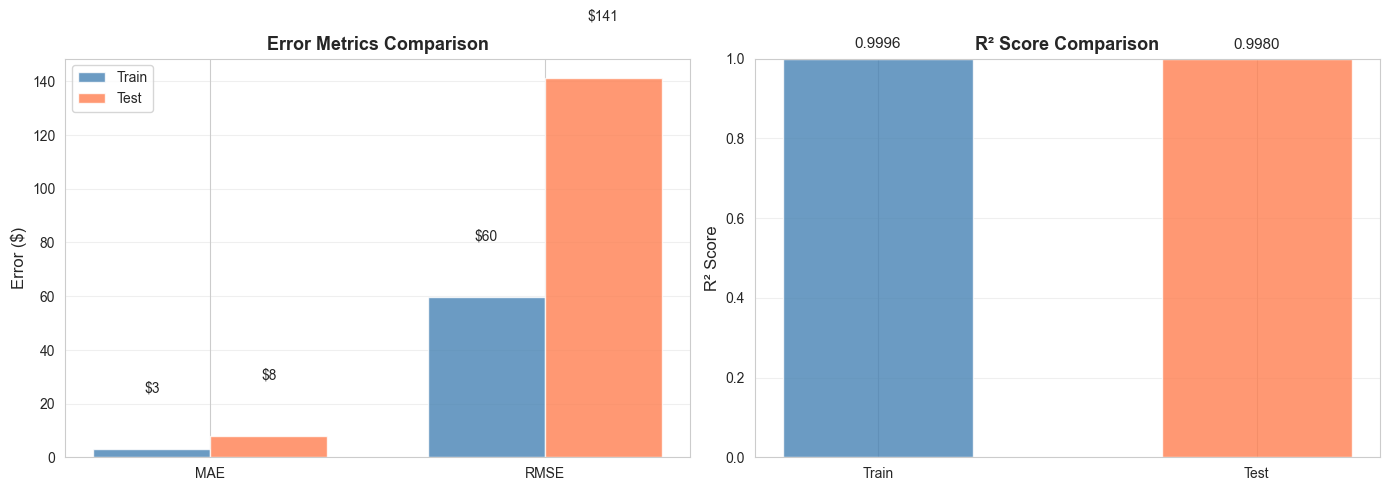

In [64]:
# Create metrics comparison chart
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# MAE/RMSE Comparison
metrics_names = ['MAE', 'RMSE']
train_vals = [train_metrics['MAE'], train_metrics['RMSE']]
test_vals = [test_metrics['MAE'], test_metrics['RMSE']]

x = np.arange(len(metrics_names))
width = 0.35

axes[0].bar(x - width/2, train_vals, width, label='Train', color='steelblue', alpha=0.8)
axes[0].bar(x + width/2, test_vals, width, label='Test', color='coral', alpha=0.8)
axes[0].set_ylabel('Error ($)', fontsize=12)
axes[0].set_title('Error Metrics Comparison', fontsize=13, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics_names)
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# Add values on bars
for i, (tv, te) in enumerate(zip(train_vals, test_vals)):
    axes[0].text(i - width/2, tv + 20, f'${tv:.0f}', ha='center', va='bottom', fontsize=10)
    axes[0].text(i + width/2, te + 20, f'${te:.0f}', ha='center', va='bottom', fontsize=10)

# R² Score Comparison
axes[1].bar(['Train', 'Test'], [train_metrics['R2'], test_metrics['R2']], 
            color=['steelblue', 'coral'], alpha=0.8, width=0.5)
axes[1].set_ylabel('R² Score', fontsize=12)
axes[1].set_title('R² Score Comparison', fontsize=13, fontweight='bold')
axes[1].set_ylim([0, 1])
axes[1].grid(True, alpha=0.3, axis='y')

# Add values on bars
axes[1].text(0, train_metrics['R2'] + 0.02, f"{train_metrics['R2']:.4f}", ha='center', va='bottom', fontsize=11)
axes[1].text(1, test_metrics['R2'] + 0.02, f"{test_metrics['R2']:.4f}", ha='center', va='bottom', fontsize=11)

plt.tight_layout()
plt.show()

## 7. Save Evaluation Results

In [65]:
# Save metrics to JSON
result_dir = base_dir / "result"
result_dir.mkdir(parents=True, exist_ok=True)

# Prepare results for saving
results_to_save = {
    'model': 'RandomForestRegressor',
    'training_metrics': {k: float(v) for k, v in train_metrics.items()},
    'test_metrics': {k: float(v) for k, v in test_metrics.items()},
    'dataset': {
        'train_samples': int(X_train.shape[0]),
        'test_samples': int(X_test.shape[0]),
        'features': int(X_train.shape[1])
    }
}

# Save to JSON
metrics_file = result_dir / "metrics.json"
with open(metrics_file, 'w') as f:
    json.dump(results_to_save, f, indent=2)

print(f"Metrics saved to: {metrics_file}")

# Also save predictions
predictions_df = pd.DataFrame({
    'actual': y_test.values,
    'predicted': y_test_pred,
    'error': residuals_test.values,
    'absolute_error': np.abs(residuals_test.values)
})

predictions_file = result_dir / "predictions_test.csv"
predictions_df.to_csv(predictions_file, index=False)
print(f"Predictions saved to: {predictions_file}")

Metrics saved to: ..\result\metrics.json
Predictions saved to: ..\result\predictions_test.csv


In [66]:
# Create detailed evaluation report
report = f"""
{'='*80}
MODEL EVALUATION REPORT
{'='*80}

MODEL INFORMATION
  Model Type: Random Forest Regressor
  Model Path: models/insurance_model.pkl

DATASET INFORMATION
  Training Samples: {X_train.shape[0]}
  Test Samples: {X_test.shape[0]}
  Features: {X_train.shape[1]}

TRAINING SET PERFORMANCE
  MAE:  ${train_metrics['MAE']:.2f}
  RMSE: ${train_metrics['RMSE']:.2f}
  MAPE: {train_metrics['MAPE']:.2%}
  R²:   {train_metrics['R2']:.4f}

TEST SET PERFORMANCE
  MAE:  ${test_metrics['MAE']:.2f}
  RMSE: ${test_metrics['RMSE']:.2f}
  MAPE: {test_metrics['MAPE']:.2%}
  R²:   {test_metrics['R2']:.4f}

INTERPRETATION
  - The model explains {test_metrics['R2']*100:.2f}% of the variance in test predictions
  - Average prediction error (MAE): ${test_metrics['MAE']:.2f}
  - Root mean squared error (RMSE): ${test_metrics['RMSE']:.2f}
  - Mean absolute percentage error: {test_metrics['MAPE']:.2%}

MODEL GENERALIZATION
  - R² Difference (Train - Test): {r2_diff:.4f}
  - Status: {'Good generalization' if r2_diff < 0.1 else 'Overfitting detected'}

{'='*80}
"""

print(report)

# Save report
report_file = result_dir / "evaluation_report.txt"
with open(report_file, 'w') as f:
    f.write(report)

print(f"Report saved to: {report_file}")


MODEL EVALUATION REPORT

MODEL INFORMATION
  Model Type: Random Forest Regressor
  Model Path: models/insurance_model.pkl

DATASET INFORMATION
  Training Samples: 80000
  Test Samples: 20000
  Features: 69

TRAINING SET PERFORMANCE
  MAE:  $3.03
  RMSE: $59.66
  MAPE: 0.05%
  R²:   0.9996

TEST SET PERFORMANCE
  MAE:  $8.06
  RMSE: $141.37
  MAPE: 0.13%
  R²:   0.9980

INTERPRETATION
  - The model explains 99.80% of the variance in test predictions
  - Average prediction error (MAE): $8.06
  - Root mean squared error (RMSE): $141.37
  - Mean absolute percentage error: 0.13%

MODEL GENERALIZATION
  - R² Difference (Train - Test): 0.0017
  - Status: Good generalization


Report saved to: ..\result\evaluation_report.txt


In [68]:
# Final summary
print("\n" + "="*80)
print("EVALUATION COMPLETE")
print("="*80)
print(f"\n✓ Model evaluated on test set")
print(f"✓ Metrics calculated and saved")
print(f"✓ Predictions generated and saved")
print(f"✓ Evaluation report created")

print(f"\nOUTPUT FILES:")
print(f"  - Metrics: result/metrics.json")
print(f"  - Predictions: result/predictions_test.csv")
print(f"  - Report: result/evaluation_report.txt")

print(f"\nKEY RESULTS:")
print(f"  - Test R² Score: {test_metrics['R2']:.4f}")
print(f"  - Test MAE: ${test_metrics['MAE']:.2f}")
print(f"  - Test RMSE: ${test_metrics['RMSE']:.2f}")

print("\n" + "="*80)


EVALUATION COMPLETE

✓ Model evaluated on test set
✓ Metrics calculated and saved
✓ Predictions generated and saved
✓ Evaluation report created

OUTPUT FILES:
  - Metrics: result/metrics.json
  - Predictions: result/predictions_test.csv
  - Report: result/evaluation_report.txt

KEY RESULTS:
  - Test R² Score: 0.9980
  - Test MAE: $8.06
  - Test RMSE: $141.37

